# Notebook 02: Datenverarbeitung und Tokenisierung

## Ziel dieses Notebooks

1. **Tokenisierung verstehen** - Wie Text zu Zahlen wird
2. **Chat-Templates anwenden** - Format für Instruct-Modelle
3. **Daten formatieren** - Training-Format erstellen
4. **Padding & Truncation** - Sequenzen vereinheitlichen
5. **Verarbeitete Daten speichern** - Für effizientes Training

---

## Theoretischer Hintergrund

### Was ist Tokenisierung?

**Tokenisierung** ist der Prozess, Text in kleinere Einheiten (Tokens) zu zerlegen und diese in Zahlen (Token-IDs) umzuwandeln.

**"Ich habe Kopfschmerzen"** 
- **Subword Tokenization:** ["Ich", "habe", "Kopf", "##schmerzen"]
- **Token-ID-Mapping:** [1234, 5678, 9012, 3456]

**Warum Subword-Tokenisierung?**
- Umgang mit unbekannten Wörtern
- Kleineres Vokabular (typisch 32K-50K)
- Mehrsprachige Unterstützung
- Effizientere Kodierung

### Was sind Chat-Templates?

Moderne **Instruct-Modelle** (wie Llama, Qwen) wurden mit speziellen Formatierungen trainiert:

```
<|system|>
Du bist ein medizinisches Assistenzsystem.
<|end|>
<|user|>
Analysiere diesen Dialog...
<|end|>
<|assistant|>
J06.9
<|end|>
```

**Warum wichtig?**
- Das Modell erwartet dieses Format
- Falsche Formatierung = schlechtere Performance
- Jedes Modell hat sein eigenes Template

---

In [1]:
# ============================================================
# SETUP: Imports und Umgebung
# ============================================================

import os
import gc
import json
import warnings
from pathlib import Path
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional
from datetime import datetime

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoTokenizer

print("Imports erfolgreich!")
print(f"   PyTorch: {torch.__version__}")

Imports erfolgreich!
   PyTorch: 2.10.0+cu128


In [2]:
# ============================================================
# KONFIGURATION
# ============================================================

@dataclass
class PathConfig:
    project_root: Path = field(default_factory=lambda: Path.cwd().parent)
    data_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data")
    cache_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data" / "cache")
    processed_data_dir: Path = field(default_factory=lambda: Path.cwd().parent / "data" / "processed")
    models_dir: Path = field(default_factory=lambda: Path.cwd().parent / "models")
    finetuned_models_dir: Path = field(default_factory=lambda: Path.cwd().parent / "models" / "finetuned")
    outputs_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs")
    plots_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "plots")
    reports_dir: Path = field(default_factory=lambda: Path.cwd().parent / "outputs" / "reports")
    
    def create_directories(self):
        for attr_name in dir(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, Path) and not attr_name.startswith('_'):
                attr.mkdir(parents=True, exist_ok=True)

@dataclass
class DataConfig:
    dataset_name: str = "Ahmad0067/MedSynth"
    dataset_split_seed: int = 42
    train_ratio: float = 0.80
    val_ratio: float = 0.10
    test_ratio: float = 0.10
    max_sequence_length: int = 4096
    truncation: bool = True
    padding: str = False
    num_workers: int = 12

@dataclass
class ModelConfig:
    # Erstes SLM für Tokenizer (alle verwenden kompatible Tokenizer)
    tokenizer_model: str = "meta-llama/Llama-3.2-3B-Instruct"

@dataclass
class Config:
    paths: PathConfig = field(default_factory=PathConfig)
    data: DataConfig = field(default_factory=DataConfig)
    model: ModelConfig = field(default_factory=ModelConfig)
    
    def setup(self):
        self.paths.create_directories()
        self._set_seeds()
    
    def _set_seeds(self):
        import random
        seed = self.data.dataset_split_seed
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

config = Config()
config.setup()

print("Konfiguration geladen!")

Konfiguration geladen!


## 1. Dataset laden

In [3]:
# ============================================================
# DATASET LADEN
# ============================================================

print(f"Lade Dataset: {config.data.dataset_name}")

dataset = load_dataset(
    config.data.dataset_name,
    cache_dir=str(config.paths.cache_dir)
)

# Wenn DatasetDict, nimm 'train' Split
if isinstance(dataset, DatasetDict):
    if "train" in dataset:
        dataset = dataset["train"]
    else:
        dataset = dataset[list(dataset.keys())[0]]

print(f"Dataset geladen: {len(dataset):,} Samples")
print(f"   Features: {list(dataset.features.keys())}")

# Identifiziere Feld-Namen
dialog_field = 'Dialogue' if 'Dialogue' in dataset.features else 'dialogue'
icd_field = 'ICD10' if 'ICD10' in dataset.features else 'icd10'

print(f"   Dialog-Feld: {dialog_field}")
print(f"   ICD-Feld: {icd_field}")

Lade Dataset: Ahmad0067/MedSynth
Dataset geladen: 10,240 Samples
   Features: [' Note', 'Dialogue', 'ICD10', 'ICD10_desc']
   Dialog-Feld: Dialogue
   ICD-Feld: ICD10


## 2. Train/Val/Test Split

### Warum 70/15/15?

- **Training (70%)**: Zum Lernen der Parameter
- **Validation (15%)**: Für Hyperparameter-Tuning und Early Stopping
- **Test (15%)**: Finale Evaluation (darf NIE ins Training!)

### Wichtig: Reproduzierbarkeit

Wir verwenden `seed=42` für reproduzierbare Splits. Das bedeutet, jedes Mal wenn wir diesen Code ausführen, erhalten wir exakt die gleichen Splits.

In [4]:
# ============================================================
# SPLIT FUNKTION (Standalone)
# ============================================================

def split_dataset(
    dataset: Dataset,
    train_ratio: float = 0.7,
    val_ratio: float = 0.15,
    test_ratio: float = 0.15,
    seed: int = 42
) -> Dict[str, Dataset]:
    """
    Splittet Datensatz in Train/Validation/Test.
    
    Args:
        dataset: Zu splittender Datensatz
        train_ratio: Anteil für Training
        val_ratio: Anteil für Validation
        test_ratio: Anteil für Test
        seed: Random Seed für Reproduzierbarkeit
    
    Returns:
        Dict mit 'train', 'validation', 'test' Datasets
    """
    # Validiere Ratios
    total = train_ratio + val_ratio + test_ratio
    if abs(total - 1.0) > 0.001:
        raise ValueError(f"Ratios müssen 1.0 ergeben, sind aber {total}")
    
    print(f"Splitte Dataset: {train_ratio:.0%} / {val_ratio:.0%} / {test_ratio:.0%}")
    
    # Erster Split: Train vs Rest
    train_test = dataset.train_test_split(
        test_size=(1 - train_ratio), 
        seed=seed
    )
    
    # Zweiter Split: Validation vs Test
    val_test = train_test["test"].train_test_split(
        test_size=(test_ratio / (val_ratio + test_ratio)), 
        seed=seed
    )
    
    splits = {
        "train": train_test["train"],
        "validation": val_test["train"],
        "test": val_test["test"],
    }
    
    print(f"   Train: {len(splits['train']):,} Samples")
    print(f"   Validation: {len(splits['validation']):,} Samples")
    print(f"   Test: {len(splits['test']):,} Samples")
    
    return splits

print("Split-Funktion definiert!")

Split-Funktion definiert!


In [5]:
# ============================================================
# DATASET SPLITTEN
# ============================================================

splits = split_dataset(
    dataset,
    train_ratio=config.data.train_ratio,
    val_ratio=config.data.val_ratio,
    test_ratio=config.data.test_ratio,
    seed=config.data.dataset_split_seed
)

train_data = splits['train']
val_data = splits['validation']
test_data = splits['test']

Splitte Dataset: 80% / 10% / 10%
   Train: 8,192 Samples
   Validation: 1,024 Samples
   Test: 1,024 Samples


## 3. Prompt-Templates definieren

### System Prompt

Der System Prompt definiert die Rolle und Aufgabe des Modells:

```
You are a medical assistance system that supports doctors in making diagnoses. Your task is to suggest the appropriate ICD-10 diagnosis code based on a doctor-patient dialogue. Respond only with the ICD-10 code, without further explanation.
```

### User Prompt

Der User Prompt enthält den Dialog und die Aufforderung:

```
Analyze the following doctor-patient dialogue and determine the appropriate ICD-10 code:

[DIALOG]

ICD-10 Code:
```

### Training vs. Inference

- **Training**: Vollständiger Prompt + ICD-10 Antwort
- **Inference**: Prompt ohne Antwort (Modell soll generieren)

In [6]:
# ============================================================
# MEDICAL DIALOG PROCESSOR (Standalone)
# ============================================================

class MedicalDialogProcessor:
    """
    Verarbeitet medizinische Dialoge für Training und Inference.
    
    Diese Klasse ist verantwortlich für:
    1. Formatierung der Dialoge mit Prompts
    2. Anwendung von Chat-Templates
    3. Tokenisierung
    """
    
    # System Prompt (konstant)
    SYSTEM_PROMPT = """You are a medical assistance system that supports doctors in making diagnoses. 
Your task is to suggest the appropriate ICD-10 diagnosis code based on a doctor-patient dialogue.
Respond only with the ICD-10 code, without further explanation."""
    
    def __init__(
        self,
        tokenizer,
        max_length: int = 512,
        padding: str = "max_length",
        truncation: bool = True
    ):
        """
        Args:
            tokenizer: HuggingFace Tokenizer
            max_length: Maximale Sequenzlänge
            padding: Padding-Strategie
            truncation: Ob Truncation aktiviert ist
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.padding = padding
        self.truncation = truncation
        
        # Stelle sicher, dass pad_token existiert
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            print(f"   pad_token auf eos_token gesetzt: {self.tokenizer.eos_token}")
    
    def format_dialog_for_training(self, conversation: str, icd_code: str) -> str:
        """
        Formatiert Dialog für Training (mit ICD-10 Antwort).
        
        Args:
            conversation: Arzt-Patient-Dialog
            icd_code: Zugehöriger ICD-10 Code
        
        Returns:
            Formatierter Text für Training
        """
        user_prompt = f"""Analyze the following doctor-patient dialogue and determine the appropriate ICD-10 code:

{conversation}

ICD-10 Code:"""
        
        # Versuche Chat-Template zu nutzen
        if hasattr(self.tokenizer, 'chat_template') and self.tokenizer.chat_template:
            messages = [
                {"role": "system", "content": self.SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt},
                {"role": "assistant", "content": icd_code}
            ]
            try:
                return self.tokenizer.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=False
                )
            except:
                pass
        
        # Fallback: Einfaches Format
        return f"System: {self.SYSTEM_PROMPT}\n\nUser: {user_prompt}\n\nAssistant: {icd_code}"
    
    def format_dialog_for_inference(self, conversation: str) -> str:
        """
        Formatiert Dialog für Inference (ohne ICD-10 Antwort).
        
        Args:
            conversation: Arzt-Patient-Dialog
        
        Returns:
            Formatierter Text für Inference
        """
        user_prompt = f"""Analyze the following doctor-patient dialogue and determine the appropriate ICD-10 code:

{conversation}

ICD-10 Code:"""
        
        # Versuche Chat-Template zu nutzen
        if hasattr(self.tokenizer, 'chat_template') and self.tokenizer.chat_template:
            messages = [
                {"role": "system", "content": self.SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt},
            ]
            try:
                return self.tokenizer.apply_chat_template(
                    messages, tokenize=False, add_generation_prompt=True
                )
            except:
                pass
        
        # Fallback: Einfaches Format
        return f"System: {self.SYSTEM_PROMPT}\n\nUser: {user_prompt}\n\nAssistant:"
    
    def tokenize_function(self, examples: Dict) -> Dict:
        """
        Tokenisiert einen Batch von Beispielen.
        
        Diese Funktion wird mit dataset.map() verwendet.
        """
        # Finde Feld-Namen
        text_field = None
        label_field = None
        
        for field in ["Dialogue", "dialogue", "conversation", "text"]:
            if field in examples:
                text_field = field
                break
        
        for field in ["ICD10", "icd10", "icd_code", "label"]:
            if field in examples:
                label_field = field
                break
        
        if not text_field or not label_field:
            raise ValueError(f"Felder nicht gefunden: {examples.keys()}")
        
        # Formatiere alle Beispiele
        formatted_texts = []
        for conv, icd in zip(examples[text_field], examples[label_field]):
            formatted = self.format_dialog_for_training(conv, icd)
            formatted_texts.append(formatted)
        
        # Tokenisiere
        tokenized = self.tokenizer(
            formatted_texts,
            padding=self.padding,
            truncation=self.truncation,
            max_length=self.max_length,
            return_tensors=None,
        )
        
        # Labels = input_ids für Causal LM
        tokenized["labels"] = tokenized["input_ids"].copy()
        
        return tokenized
    
    def process_dataset(self, dataset: Dataset, num_proc: int = 4) -> Dataset:
        """
        Verarbeitet kompletten Datensatz.
        
        Args:
            dataset: Rohdatensatz
            num_proc: Anzahl paralleler Prozesse
        
        Returns:
            Tokenisierter Datensatz
        """
        print(f"🔄 Verarbeite Dataset mit {num_proc} Prozessen...")
        
        # Spalten die entfernt werden
        columns_to_remove = [col for col in dataset.column_names 
                           if col not in ['input_ids', 'attention_mask', 'labels']]
        
        processed = dataset.map(
            self.tokenize_function,
            batched=True,
            batch_size=1000,
            num_proc=num_proc,
            remove_columns=columns_to_remove,
            desc="Tokenisierung"
        )
        
        print(f"Verarbeitet: {len(processed):,} Samples")
        return processed

print("MedicalDialogProcessor definiert!")

MedicalDialogProcessor definiert!


## 4. Tokenizer laden & verstehen

### 4.1 Der Tokenizer

Jedes Modell hat seinen eigenen Tokenizer.

In [7]:
# ============================================================
# TOKENIZER LADEN
# ============================================================

print(f"Lade Tokenizer: {config.model.tokenizer_model}")

tokenizer = AutoTokenizer.from_pretrained(config.model.tokenizer_model)

# Padding-Einstellungen
tokenizer.padding_side = "left"  # Wichtig für Decoder-Only Modelle!
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer geladen!")
print(f"   Vocab Size: {tokenizer.vocab_size:,}")
print(f"   Padding Side: {tokenizer.padding_side}")
print(f"   Pad Token: {tokenizer.pad_token}")
print(f"   EOS Token: {tokenizer.eos_token}")

Lade Tokenizer: meta-llama/Llama-3.2-3B-Instruct
Tokenizer geladen!
   Vocab Size: 128,000
   Padding Side: left
   Pad Token: <|eot_id|>
   EOS Token: <|eot_id|>


In [8]:
# ============================================================
# PROCESSOR ERSTELLEN
# ============================================================

processor = MedicalDialogProcessor(
    tokenizer=tokenizer,
    max_length=config.data.max_sequence_length,
    padding=config.data.padding,
    truncation=config.data.truncation
)

print("Processor erstellt!")

Processor erstellt!


### 4.2 Tokenisierung verstehen

In [9]:
# ============================================================
# TOKENISIERUNG: Beispiel demonstrieren
# ============================================================

example_text = "Der Patient klagt über starke Kopfschmerzen und Fieber."

print("Tokenisierungs-Beispiel:")
print("=" * 60)
print(f"Original-Text: '{example_text}'")

# Tokenisieren
tokens = tokenizer.tokenize(example_text)
token_ids = tokenizer.encode(example_text, add_special_tokens=False)

print(f"\nTokens: {tokens}")
print(f"Token-IDs: {token_ids}")
print(f"Anzahl Tokens: {len(tokens)}")

# Dekodieren zurück zu Text
decoded = tokenizer.decode(token_ids)
print(f"\nDekodiert: '{decoded}'")

# Token-ID Mapping zeigen
print(f"\nToken-zu-ID Mapping:")
for token, token_id in zip(tokens, token_ids):
    print(f"   '{token}' → {token_id}")

Tokenisierungs-Beispiel:
Original-Text: 'Der Patient klagt über starke Kopfschmerzen und Fieber.'

Tokens: ['Der', 'ĠPatient', 'Ġk', 'lag', 't', 'ĠÃ¼ber', 'Ġstar', 'ke', 'ĠKop', 'fs', 'ch', 'mer', 'zen', 'Ġund', 'ĠF', 'ieber', '.']
Token-IDs: [22960, 30024, 597, 13667, 83, 14104, 6917, 441, 59109, 3933, 331, 1195, 5797, 2073, 435, 61341, 13]
Anzahl Tokens: 17

Dekodiert: 'Der Patient klagt über starke Kopfschmerzen und Fieber.'

Token-zu-ID Mapping:
   'Der' → 22960
   'ĠPatient' → 30024
   'Ġk' → 597
   'lag' → 13667
   't' → 83
   'ĠÃ¼ber' → 14104
   'Ġstar' → 6917
   'ke' → 441
   'ĠKop' → 59109
   'fs' → 3933
   'ch' → 331
   'mer' → 1195
   'zen' → 5797
   'Ġund' → 2073
   'ĠF' → 435
   'ieber' → 61341
   '.' → 13


In [10]:
# ============================================================
# SPEZIAL-TOKENS: Wichtige Token-IDs zeigen
# ============================================================

print("Wichtige Spezial-Tokens:")
print("=" * 60)

special_tokens = {
    "PAD (Padding)": tokenizer.pad_token_id,
    "EOS (End of Sequence)": tokenizer.eos_token_id,
    "BOS (Beginning of Sequence)": tokenizer.bos_token_id,
    "UNK (Unknown)": tokenizer.unk_token_id,
}

for name, token_id in special_tokens.items():
    if token_id is not None:
        token_text = tokenizer.decode([token_id])
        print(f"   {name:30} → ID: {token_id:5} ('{token_text}')")
    else:
        print(f"   {name:30} → Nicht definiert")

Wichtige Spezial-Tokens:
   PAD (Padding)                  → ID: 128009 ('<|eot_id|>')
   EOS (End of Sequence)          → ID: 128009 ('<|eot_id|>')
   BOS (Beginning of Sequence)    → ID: 128000 ('<|begin_of_text|>')
   UNK (Unknown)                  → Nicht definiert


In [11]:
# ============================================================
# BEISPIEL: FORMATIERUNG ANZEIGEN
# ============================================================

# Hole Beispiel-Sample
example = train_data[0]
example_dialog = example[dialog_field]
example_icd = example[icd_field]

print("Original-Dialog (gekürzt):")
print("=" * 60)
print(example_dialog[:500] + "...")

print(f"\nICD-10 Code: {example_icd}")

Original-Dialog (gekürzt):
[doctor] Hello, how are you doing today? What brings you to the emergency department?

[patient] Hi, I'm not doing well. I've been having severe pain and redness in my right leg, and I've been running a high fever. It's been really bad.

[doctor] I'm sorry to hear that. Can you tell me more about when you first noticed these symptoms?

[patient] I first noticed the pain and redness about 5 days ago. It started off mild, but it has gotten much worse. The fever started around the same time.

[doct...

ICD-10 Code: B9562


In [12]:
# ============================================================
# BEISPIEL: TRAINING-FORMAT
# ============================================================

formatted_training = processor.format_dialog_for_training(example_dialog, example_icd)

print("Formatiert für TRAINING:")
print("=" * 60)
print(formatted_training[:800])
if len(formatted_training) > 800:
    print("...")

Formatiert für TRAINING:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 Feb 2026

You are a medical assistance system that supports doctors in making diagnoses. 
Your task is to suggest the appropriate ICD-10 diagnosis code based on a doctor-patient dialogue.
Respond only with the ICD-10 code, without further explanation.<|eot_id|><|start_header_id|>user<|end_header_id|>

Analyze the following doctor-patient dialogue and determine the appropriate ICD-10 code:

[doctor] Hello, how are you doing today? What brings you to the emergency department?

[patient] Hi, I'm not doing well. I've been having severe pain and redness in my right leg, and I've been running a high fever. It's been really bad.

[doctor] I'm sorry to hear that. Can you tell me more a
...


In [13]:
# ============================================================
# BEISPIEL: INFERENCE-FORMAT
# ============================================================

formatted_inference = processor.format_dialog_for_inference(example_dialog)

print("Formatiert für INFERENCE:")
print("=" * 60)
print(formatted_inference[:800])
if len(formatted_inference) > 800:
    print("...")

Formatiert für INFERENCE:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 Feb 2026

You are a medical assistance system that supports doctors in making diagnoses. 
Your task is to suggest the appropriate ICD-10 diagnosis code based on a doctor-patient dialogue.
Respond only with the ICD-10 code, without further explanation.<|eot_id|><|start_header_id|>user<|end_header_id|>

Analyze the following doctor-patient dialogue and determine the appropriate ICD-10 code:

[doctor] Hello, how are you doing today? What brings you to the emergency department?

[patient] Hi, I'm not doing well. I've been having severe pain and redness in my right leg, and I've been running a high fever. It's been really bad.

[doctor] I'm sorry to hear that. Can you tell me more a
...


In [14]:
# ============================================================
# BEISPIEL: TOKENISIERUNG
# ============================================================

# Tokenisiere Beispiel
tokens = tokenizer(formatted_training, return_tensors="pt", truncation=True, max_length=512)

print("Tokenisierung:")
print("=" * 60)
print(f"   Input IDs Shape: {tokens['input_ids'].shape}")
print(f"   Attention Mask Shape: {tokens['attention_mask'].shape}")
print(f"   Anzahl Tokens: {tokens['input_ids'].shape[1]}")
print(f"\n   Erste 20 Token-IDs: {tokens['input_ids'][0][:20].tolist()}")
print(f"   Letzte 10 Token-IDs: {tokens['input_ids'][0][-10:].tolist()}")

# Dekodiere zurück
decoded = tokenizer.decode(tokens['input_ids'][0], skip_special_tokens=False)
print(f"\n   Dekodiert (erste 200 Zeichen):\n   {decoded[:200]}...")

Tokenisierung:
   Input IDs Shape: torch.Size([1, 512])
   Attention Mask Shape: torch.Size([1, 512])
   Anzahl Tokens: 512

   Erste 20 Token-IDs: [128000, 128000, 128006, 9125, 128007, 271, 38766, 1303, 33025, 2696, 25, 6790, 220, 2366, 18, 198, 15724, 2696, 25, 220]
   Letzte 10 Token-IDs: [5789, 315, 6784, 477, 8541, 29668, 28858, 701, 1314, 4827]

   Dekodiert (erste 200 Zeichen):
   <|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 01 Feb 2026

You are a medical assistance system that supports doctors i...


## 6. Datasets verarbeiten

In [15]:
# ============================================================
# TRAINING-DATASET VERARBEITEN
# ============================================================

print("Verarbeite Training-Dataset...")
train_processed = processor.process_dataset(
    train_data, 
    num_proc=config.data.num_workers
)

print(f"\nTraining-Dataset:")
print(f"   Features: {train_processed.features}")
print(f"   Größe: {len(train_processed):,}")

# ============================================================
# ORIGINAL TOKEN-LÄNGEN ANALYSIEREN (ohne Truncation)
# ============================================================

# Tokenisiere alle Trainings-Samples ohne Truncation
original_token_lengths = []
for sample in tqdm(train_data, desc="Analysiere Original-Längen"):
    # Formatieren wie im Training
    formatted = processor.format_dialog_for_training(
        sample[dialog_field], sample[icd_field]
    )
    # Tokenisieren ohne Truncation
    tokens = tokenizer.encode(formatted, truncation=False)
    original_token_lengths.append(len(tokens))

print("Original Token-Längen-Statistiken (ohne Truncation):")
print("=" * 60)
print(f"   Mittelwert: {np.mean(original_token_lengths):.1f}")
print(f"   Median: {np.median(original_token_lengths):.1f}")
print(f"   Min: {np.min(original_token_lengths)}")
print(f"   Max: {np.max(original_token_lengths)}")
print(f"   Std: {np.std(original_token_lengths):.1f}")

Verarbeite Training-Dataset...
🔄 Verarbeite Dataset mit 12 Prozessen...


Tokenisierung (num_proc=12): 100%|██████████| 8192/8192 [00:03<00:00, 2410.90 examples/s]


Verarbeitet: 8,192 Samples

Training-Dataset:
   Features: {'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8')), 'labels': List(Value('int64'))}
   Größe: 8,192


Analysiere Original-Längen: 100%|██████████| 8192/8192 [00:10<00:00, 768.60it/s]

Original Token-Längen-Statistiken (ohne Truncation):
   Mittelwert: 1166.8
   Median: 1157.0
   Min: 114
   Max: 4219
   Std: 149.6


In [16]:
# ============================================================
# VALIDATION-DATASET VERARBEITEN
# ============================================================

print("Verarbeite Validation-Dataset...")
val_processed = processor.process_dataset(
    val_data, 
    num_proc=config.data.num_workers
)

print(f"\nValidation-Dataset:")
print(f"   Features: {val_processed.features}")
print(f"   Größe: {len(val_processed):,}")

Verarbeite Validation-Dataset...
🔄 Verarbeite Dataset mit 12 Prozessen...


Tokenisierung (num_proc=12): 100%|██████████| 1024/1024 [00:02<00:00, 459.76 examples/s]

Verarbeitet: 1,024 Samples

Validation-Dataset:
   Features: {'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8')), 'labels': List(Value('int64'))}
   Größe: 1,024


In [17]:
# ============================================================
# TEST-DATASET (bleibt roh für Evaluation)
# ============================================================

print("Test-Dataset bleibt unverarbeitet (rohe Dialoge für Evaluation)")
print(f"   Features: {test_data.features}")
print(f"   Größe: {len(test_data):,}")

Test-Dataset bleibt unverarbeitet (rohe Dialoge für Evaluation)
   Features: {' Note': Value('string'), 'Dialogue': Value('string'), 'ICD10': Value('string'), 'ICD10_desc': Value('string')}
   Größe: 1,024


## 7. Token-Längen analysieren

In [23]:
# ============================================================
# TOKEN-LÄNGEN ANALYSIEREN
# ============================================================

# Extrahiere Token-Längen
token_lengths = [len(sample['input_ids']) for sample in tqdm(train_processed, desc="Analysiere Längen")]

print("Token-Längen-Statistiken:")
print("=" * 60)
print(f"   Mittelwert: {np.mean(token_lengths):.1f}")
print(f"   Median: {np.median(token_lengths):.1f}")
print(f"   Min: {np.min(token_lengths)}")
print(f"   Max: {np.max(token_lengths)}")
print(f"   Std: {np.std(token_lengths):.1f}")

# Prüfe Truncation
max_len = config.data.max_sequence_length
truncated = sum(1 for l in token_lengths if l == max_len)
print(f"\nTruncated Samples: {truncated} ({truncated/len(token_lengths)*100:.1f}%)")

Analysiere Längen: 100%|██████████| 8192/8192 [00:05<00:00, 1615.60it/s]

Token-Längen-Statistiken:
   Mittelwert: 1166.8
   Median: 1157.0
   Min: 114
   Max: 4096
   Std: 149.3

Truncated Samples: 1 (0.0%)


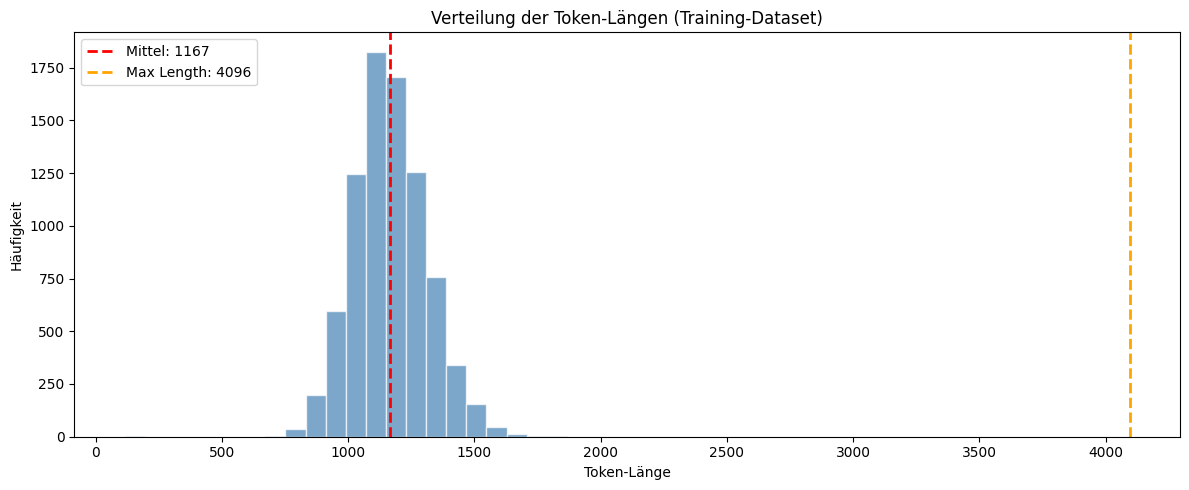

Plot gespeichert: /home/bmw/src/simon/finetuning/outputs/plots/token_lengths.png


In [25]:
# ============================================================
# VISUALISIERUNG: TOKEN-LÄNGEN
# ============================================================

fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(token_lengths, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax.axvline(np.mean(token_lengths), color='red', linestyle='--', linewidth=2, 
           label=f'Mittel: {np.mean(token_lengths):.0f}')
ax.axvline(config.data.max_sequence_length, color='orange', linestyle='--', linewidth=2,
           label=f'Max Length: {config.data.max_sequence_length}')
ax.set_xlabel('Token-Länge')
ax.set_ylabel('Häufigkeit')
ax.set_title('Verteilung der Token-Längen (Training-Dataset)')
ax.legend()

plt.tight_layout()
plt.savefig(config.paths.plots_dir / 'token_lengths.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Plot gespeichert: {config.paths.plots_dir / 'token_lengths.png'}")

## 9. Padding und Attention Mask verstehen

### 9.1 Was ist Padding?

**Padding** fügt spezielle Tokens hinzu, um alle Sequenzen auf die gleiche Länge zu bringen.

```
Ohne Padding:
  Sample 1: [A, B, C, D, E]     (5 Tokens)
  Sample 2: [A, B, C]           (3 Tokens)
  
Mit Padding (max_length=5):
  Sample 1: [A, B, C, D, E]     (5 Tokens)
  Sample 2: [PAD, PAD, A, B, C] (5 Tokens, links gepaddet)
```

### 9.2 Warum links Padding?

Für **Decoder-Only Modelle** (wie Llama, GPT) ist **Left-Padding** wichtig:
- Das Modell generiert von links nach rechts
- PAD-Tokens am Ende würden die Generation stören
- Links Padding: Relevante Tokens sind am Ende (wo generiert wird)

In [32]:
# ============================================================
# PADDING: Visualisieren wie Padding funktioniert
# ============================================================

print("Padding-Beispiel:")
print("=" * 60)

# Finde ein kurzes und ein langes Beispiel
short_idx = min(range(len(token_lengths)), key=lambda i: token_lengths[i])
long_idx = max(range(len(token_lengths)), key=lambda i: token_lengths[i])

for name, idx in [("Kurzes", short_idx), ("Langes", long_idx)]:
    sample = train_processed[idx]
    ids = sample['input_ids']
    mask = sample['attention_mask']
    
    # Zähle PAD-Tokens (wo mask=0)
    pad_count = sum(1 for m in mask if m == 0)
    content_count = sum(mask)
    
    print(f"\n{name} Beispiel (Index {idx}):")
    print(f"   Gesamtlänge: {len(ids)}")
    print(f"   Content-Tokens: {content_count}")
    print(f"   PAD-Tokens: {pad_count}")
    print(f"   Erste 10 IDs: {ids[:10]}")
    print(f"   Erste 10 Mask: {mask[:10]}")

Padding-Beispiel:

Kurzes Beispiel (Index 1387):
   Gesamtlänge: 114
   Content-Tokens: 114
   PAD-Tokens: 0
   Erste 10 IDs: [128000, 128000, 128006, 9125, 128007, 271, 38766, 1303, 33025, 2696]
   Erste 10 Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Langes Beispiel (Index 6042):
   Gesamtlänge: 4096
   Content-Tokens: 4096
   PAD-Tokens: 0
   Erste 10 IDs: [128000, 128000, 128006, 9125, 128007, 271, 38766, 1303, 33025, 2696]
   Erste 10 Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## 10. Verarbeitete Daten speichern

In [26]:
# ============================================================
# DATASETS SPEICHERN
# ============================================================

# Speicherpfade
train_path = config.paths.processed_data_dir / "train"
val_path = config.paths.processed_data_dir / "validation"
test_path = config.paths.processed_data_dir / "test_raw"

# Speichern
print("Speichere verarbeitete Datasets...")

train_processed.save_to_disk(str(train_path))
print(f"   Training: {train_path}")

val_processed.save_to_disk(str(val_path))
print(f"   Validation: {val_path}")

test_data.save_to_disk(str(test_path))
print(f"   Test (raw): {test_path}")

Speichere verarbeitete Datasets...


Saving the dataset (1/1 shards): 100%|██████████| 8192/8192 [00:00<00:00, 84939.53 examples/s]


   Training: /home/bmw/src/simon/finetuning/data/processed/train


Saving the dataset (1/1 shards): 100%|██████████| 1024/1024 [00:00<00:00, 73259.20 examples/s]


   Validation: /home/bmw/src/simon/finetuning/data/processed/validation


Saving the dataset (1/1 shards): 100%|██████████| 1024/1024 [00:00<00:00, 87616.63 examples/s]

   Test (raw): /home/bmw/src/simon/finetuning/data/processed/test_raw


In [27]:
# ============================================================
# ZUSAMMENFASSUNG SPEICHERN
# ============================================================

processing_summary = {
    "dataset_name": config.data.dataset_name,
    "tokenizer_model": config.model.tokenizer_model,
    "max_sequence_length": config.data.max_sequence_length,
    "split_ratios": {
        "train": config.data.train_ratio,
        "validation": config.data.val_ratio,
        "test": config.data.test_ratio
    },
    "split_seed": config.data.dataset_split_seed,
    "dataset_sizes": {
        "train": len(train_processed),
        "validation": len(val_processed),
        "test": len(test_data)
    },
    "token_length_stats": {
        "mean": float(np.mean(token_lengths)),
        "median": float(np.median(token_lengths)),
        "min": int(np.min(token_lengths)),
        "max": int(np.max(token_lengths)),
        "truncated_count": truncated,
        "truncated_percent": truncated/len(token_lengths)*100
    },
    "processed_at": datetime.now().isoformat()
}

summary_path = config.paths.reports_dir / "processing_summary.json"
with open(summary_path, 'w') as f:
    json.dump(processing_summary, f, indent=2)

print(f"Zusammenfassung gespeichert: {summary_path}")

Zusammenfassung gespeichert: /home/bmw/src/simon/finetuning/outputs/reports/processing_summary.json


In [28]:
# ============================================================
# FINALE ZUSAMMENFASSUNG
# ============================================================

print("=" * 60)
print("ZUSAMMENFASSUNG: Datenverarbeitung")
print("=" * 60)
print(f"""
Verarbeitung abgeschlossen!

Dataset-Splits:
   - Training: {len(train_processed):,} Samples
   - Validation: {len(val_processed):,} Samples
   - Test: {len(test_data):,} Samples

Tokenisierung:
   - Tokenizer: {config.model.tokenizer_model}
   - Max Length: {config.data.max_sequence_length}
   - Durchschn. Token-Länge: {np.mean(token_lengths):.0f}
   - Truncated: {truncated} ({truncated/len(token_lengths)*100:.1f}%)

Gespeicherte Dateien:
   - {train_path}
   - {val_path}
   - {test_path}
   - {summary_path}

Nächster Schritt: Notebook 03 - LLM Evaluation (Zero-Shot)
""")

ZUSAMMENFASSUNG: Datenverarbeitung

Verarbeitung abgeschlossen!

Dataset-Splits:
   - Training: 8,192 Samples
   - Validation: 1,024 Samples
   - Test: 1,024 Samples

Tokenisierung:
   - Tokenizer: meta-llama/Llama-3.2-3B-Instruct
   - Max Length: 4096
   - Durchschn. Token-Länge: 1167
   - Truncated: 1 (0.0%)

Gespeicherte Dateien:
   - /home/bmw/src/simon/finetuning/data/processed/train
   - /home/bmw/src/simon/finetuning/data/processed/validation
   - /home/bmw/src/simon/finetuning/data/processed/test_raw
   - /home/bmw/src/simon/finetuning/outputs/reports/processing_summary.json

Nächster Schritt: Notebook 03 - LLM Evaluation (Zero-Shot)

